# Random Digits Exercice

### Description:
This is an exercise in hypothesis testing, specifically determining if a series of digits [0,9] is random or not, and if the origin is human (i.e. yourself!). In order to determine this, one has to design and apply statistical tests, from which the degree of consistency of being random can be calculated.

### Your task:
Using tests of your choice/design, determine which of the seven data sets are consistent with being random, and which aren't. One is based on the digits you entered in the course questionaire, while the others range from obviously non-random over poor/quasi random to truly random. See if you among these can determine your (human) dataset.

###  Author: 
 - Troels Petersen ([petersen@nbi.dk](mailto:petersen@nbi.dk))

###  Date:
 - 7th of December 2022

---

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder
plt.style.use('classic')                               # Use classic style for plots
from numba import njit                                  # Module to use JIT compilation

In [3]:
r = np.random
r.seed(1234)                                           # Set seed for reproducibility

data_random_uni = np.int64(r.uniform(0, 10, 1000000))               # Generate 1000 random numbers between 0 and 1
print(data_random_uni)

[1 6 4 ... 5 7 0]


In [4]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [5]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

---
## Import random numbers from text file:

In [6]:
# Define list of input files:
dataset_letter='A' # between A and G
infiles = ["data_RandomDigits2022_" + dataset_letter + ".txt" ]

In [7]:
# List containing all numbers:
numbers = []

# Loop over input files open them in read mode
for ifile in infiles : 
    with open( ifile, "r" ) as current_file : 
        # Extract current file info : Loop through each line in the file, loop through each character
        # in the line, demand character is not empty ("") and convert the result to an integer
        # Finally add result to the numbers list
        numbers += [int(char) for line in current_file for char in line.strip() if char is not ""]

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\Jakob\AppData\Local\Temp\ipykernel_17060\4027097661.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  numbers += [int(char) for line in current_file for char in line.strip() if char is not ""]


(array([559., 555., 564., 554., 562., 553., 562., 564., 557., 557.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

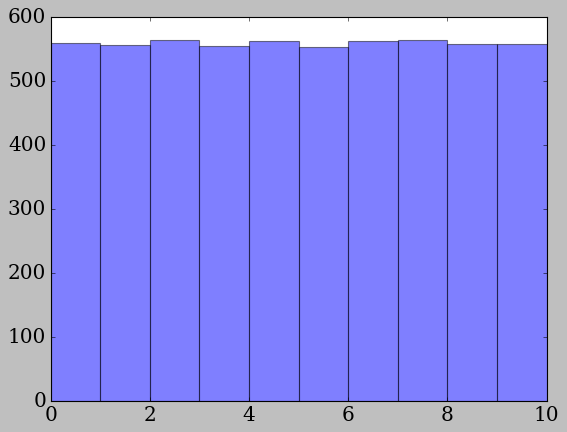

In [8]:
plt.hist(numbers, bins=10, range=(0,10), histtype='bar', color='blue',alpha=0.5, label='Data')

In [9]:
# Always take a look at the data:
numbers = np.array(numbers)
print(numbers, len(numbers))
print(numbers[:800])

[5 2 9 ... 8 5 2] 5587
[5 2 9 6 3 0 7 4 1 8 5 6 3 0 7 4 1 8 5 2 9 6 5 2 9 6 3 0 7 4 1 8 5 7 4 1 8
 5 2 9 6 3 0 7 0 7 4 1 8 5 2 9 6 3 0 4 1 8 5 2 9 6 3 0 7 4 2 9 6 3 0 7 4 1
 8 5 2 7 4 1 8 5 2 9 6 3 0 7 8 5 2 9 6 3 0 7 4 1 8 2 9 6 3 0 7 4 1 8 5 2 0
 7 4 1 8 5 2 9 6 3 0 2 9 6 3 0 7 4 1 8 5 2 1 8 5 2 9 6 3 0 7 4 1 3 0 7 4 1
 8 5 2 9 6 3 5 2 9 6 3 0 7 4 1 8 5 9 6 3 0 7 4 1 8 5 2 9 3 0 7 4 1 8 5 2 9
 6 3 2 9 6 3 0 7 4 1 8 5 2 1 8 5 2 9 6 3 0 7 4 1 1 8 5 2 9 6 3 0 7 4 1 1 8
 5 2 9 6 3 0 7 4 1 7 4 1 8 5 2 9 6 3 0 7 0 7 4 1 8 5 2 9 6 3 0 9 6 3 0 7 4
 1 8 5 2 9 5 2 9 6 3 0 7 4 1 8 5 5 2 9 6 3 0 7 4 1 8 5 3 0 7 4 1 8 5 2 9 6
 3 6 3 0 7 4 1 8 5 2 9 6 4 1 8 5 2 9 6 3 0 7 4 3 0 7 4 1 8 5 2 9 6 3 2 9 6
 3 0 7 4 1 8 5 2 9 6 3 0 7 4 1 8 5 2 9 2 9 6 3 0 7 4 1 8 5 2 4 1 8 5 2 9 6
 3 0 7 4 3 0 7 4 1 8 5 2 9 6 3 0 7 4 1 8 5 2 9 6 3 0 1 8 5 2 9 6 3 0 7 4 1
 1 8 5 2 9 6 3 0 7 4 1 6 3 0 7 4 1 8 5 2 9 6 4 1 8 5 2 9 6 3 0 7 4 7 4 1 8
 5 2 9 6 3 0 7 7 4 1 8 5 2 9 6 3 0 7 1 8 5 2 9 6 3 0 7 4 1 5 2 9 6 3 0 7 4
 1

---
## Define your tests:

Here is an example plot from the data, just for convenience. It is all up to you from here...

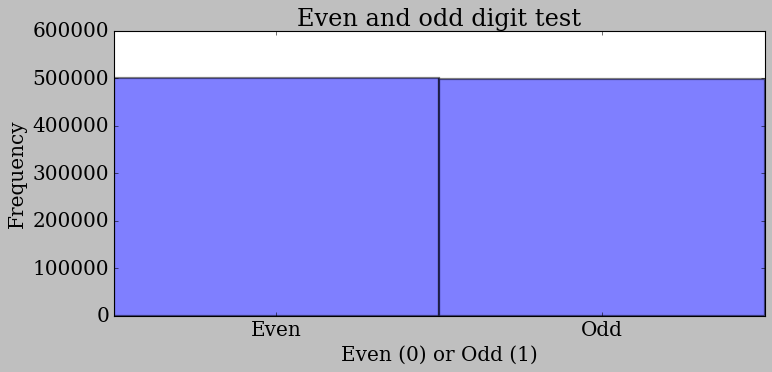

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

def even_odd_test(x):
    return x%2

count, bins, _ = ax.hist(data_random_uni%2, bins=2, range=(-0.5, 1.5), density=False, lw=2, histtype='bar',alpha=0.5, label='Data') 
ax.set(xlabel="Even (0) or Odd (1)", ylabel="Frequency", title="Even and odd digit test")
ax.xaxis.set_ticks([0, 1])
ax.set_xticklabels(["Even", "Odd"])
fig.tight_layout()
expected = np.array([len(numbers)/2, len(numbers)/2])
chi2 = np.sum

p_value =  0.0


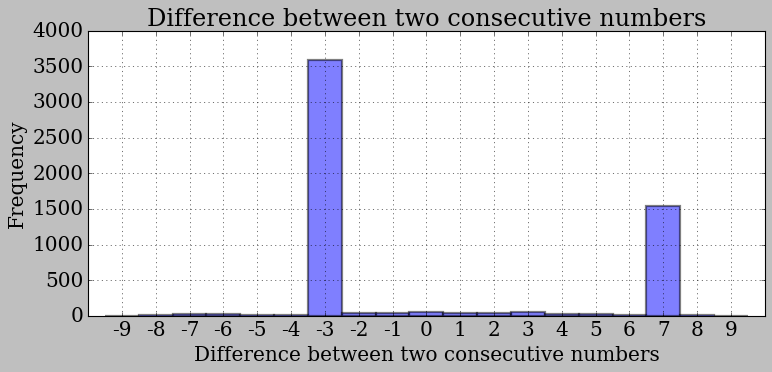

In [11]:
## differents between the two closest numbers
def diff_test(numbers):
    return np.diff(numbers)

diff = diff_test(numbers)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
binmin, binmax = -9.5, 9.5
N_bins = 19
binwidth = (binmax - binmin) / N_bins
count, bins,_ = ax.hist(diff, bins= N_bins, range=(binmin, binmax),  histtype='bar', density=False, lw=2, alpha=0.5, label='Data')
ax.set(xlabel="Difference between two consecutive numbers", ylabel="Frequency", title="Difference between two consecutive numbers")
ax.set_xticks(np.arange(-9, 10, 1))
ax.set_xticklabels(np.arange(-9, 10, 1))
ax.set_title("Difference between two consecutive numbers")
ax.grid()
fig.tight_layout()

expected = np.arange(0,19) - 9
a = np.arange(0.01, 0.11, 0.01)
b = np.arange(0.01, 0.10, 0.01)
c = (np.array((list(a)+list(b[::-1]))) * binwidth * len(diff)).round(0)

chi2 = np.sum((count - c)**2 / count)
print('p_value = ', stats.chi2.sf(chi2, 19))

[0.1        0.09       0.081      0.0729     0.06561    0.059049
 0.0531441  0.04782969 0.04304672 0.03874205 0.03486784 0.03138106
 0.02824295 0.02541866 0.02287679 0.02058911 0.0185302  0.01667718
 0.01500946 0.01350852 0.01215767 0.0109419  0.00984771 0.00886294
 0.00797664 0.00717898 0.00646108 0.00581497 0.00523348 0.00471013
 0.00423912 0.0038152  0.00343368 0.00309032 0.00278128 0.00250316
 0.00225284 0.00202756 0.0018248  0.00164232 0.00147809 0.00133028
 0.00119725 0.00107753 0.00096977 0.0008728  0.00078552 0.00070697
 0.00063627 0.00057264 0.00051538 0.00046384 0.00041746 0.00037571
 0.00033814 0.00030433 0.00027389 0.0002465  0.00022185 0.00019967
 0.0001797 ]


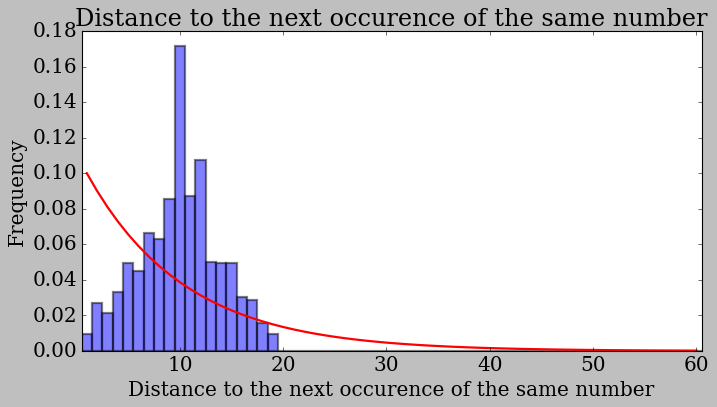

In [12]:
njit()
def dist_to_same(numbers):
    dist = []
    for i in range(len(numbers)):
        for j in range(i+1,len(numbers)):
            if numbers[i] == numbers[j]:
                dist.append(j-i)
                break
    return dist
dist = dist_to_same(numbers)
binmax, binmin = 60.5, 0.5
N_bins = 60
binwidth = (binmax - binmin) / N_bins
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
count, bins, _ = ax.hist(dist, bins=N_bins, range=(binmin, binmax), histtype='bar', density=True, lw=2, alpha=0.5, label='Data')
bin_center = (bins[:-1] + bins[1:]) / 2
ax.set(xlabel="Distance to the next occurence of the same number", ylabel="Frequency", title="Distance to the next occurence of the same number")
#ax.set_xticklabels(np.arange(0, 100, 1), rotation=45)
ax.set_xlim(0.5, 60.5)

def expected_dist(n):
    return 1/10 * (9/10)**n

x = np.arange(0, 61)
y = expected_dist(x)
print(y)
ax.plot(bin_center, y[:60], 'r-', lw=2, label='Expected')



(array([8.99717e+05, 9.02500e+04, 9.00200e+03, 9.28000e+02, 9.40000e+01,
        8.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <BarContainer object of 10 artists>)

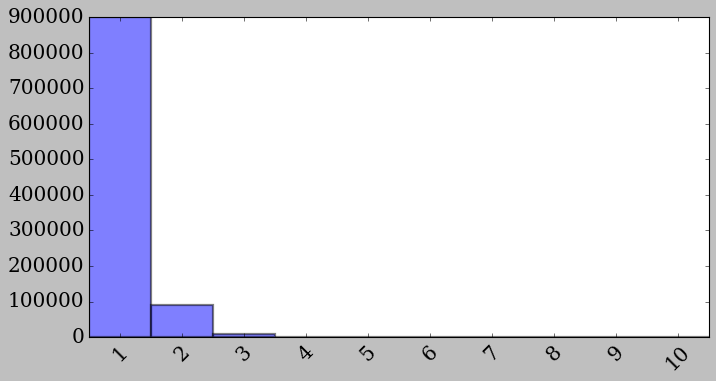

In [13]:
njit()
def runs_test(numbers):
    runs = []
    for i in range(len(numbers)):
        run = 1
        for j in range(i+1,len(numbers)):
            if numbers[i] == numbers[j]:
                run += 1
            else:
                runs.append(run)
                break
    return runs

runs = runs_test(data_random_uni)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
#ax.set(xlabel="Number of consecutive occurences of the same number", ylabel="Frequency", title="Number of consecutive occurences of the same number")
ax.set_xticks(np.arange(1, 11, 1))
ax.set_xticklabels(np.arange(1, 11, 1), rotation=45)
ax.hist(runs, bins=10, range=(0.5, 10.5), histtype='bar', density=False, lw=2, alpha=0.5, label='Data')



[Text(-1, 0, 'Under'), Text(0, 0, 'Equal'), Text(1, 0, 'Over')]

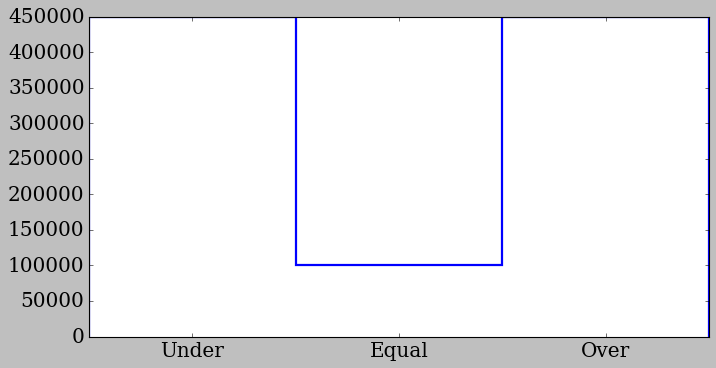

In [14]:
njit()
def over_under_test(numbers):
    under = []
    equal = []
    over = []
    for i in range(len(numbers)-1):
        if numbers[i] > numbers[i+1]:
            over.append(1)
        elif numbers[i] == numbers[i+1]:
            equal.append(0)
        else:
            under.append(-1)
        
    values = under + equal + over
    return values

val = over_under_test(data_random_uni)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.hist(val, bins=3, range=(-1.5, 1.5), histtype='step', density=False, lw=2)
ax.set_xticks([-1,0,1],[-1, 0, 1])
ax.set_xticklabels(["Under", "Equal", "Over"])


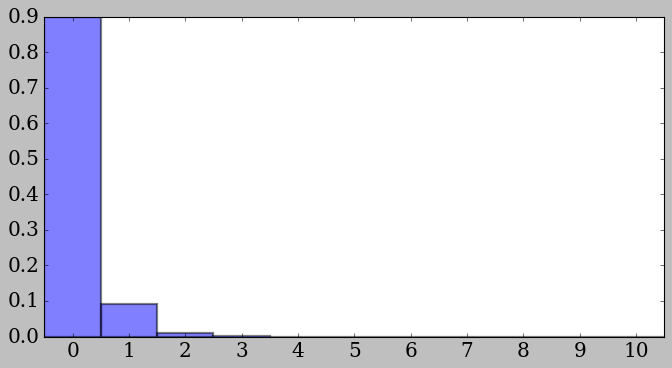

In [15]:
njit()
def sequential_test(numbers):
    save = []
    for i in range(len(numbers)):
        for j in range(i+1,len(numbers)):
            if j == i+1:
                save_number = j 
            
            if numbers[i] != numbers[j]:
                if j == save_number:
                    save.append(0)
                else:
                    save.append(j-i-1)
                break
    return save
    
seq = sequential_test(data_random_uni)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.hist(seq, bins=11, range=(-0.5, 10.5), histtype='bar', density=True, lw=2, alpha=0.5, label='Data')
ax.set_xticks(np.arange(0, 11, 1))
ax.set_xticklabels(np.arange(0, 11, 1));
ax.set_xlim(-0.5, 10.5);




ValueError: x and y must have same first dimension, but have shapes (1000000,) and (0,)

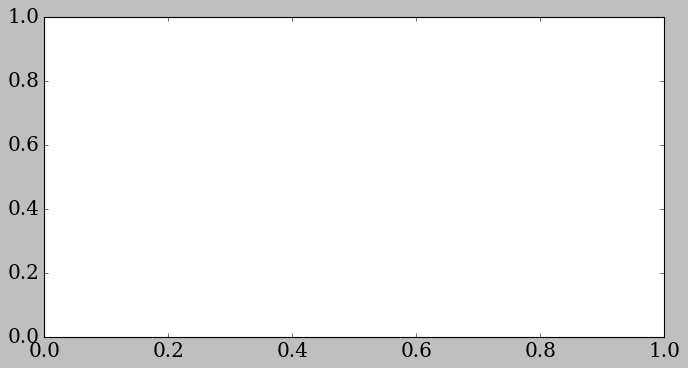

In [47]:
## use fast fourier transform to find the frequency of the data
def fft_test(numbers):
    np.fft.fft(numbers)
    return fft

fft = fft_test(data_random_uni)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(data_random_uni, fft, '.', lw=2, label='Expected')
ax.set(xlabel="Frequency", ylabel="Amplitude", title="Frequency of the data")
ax.set_xlim(0, 10)
ax.set_ylim(-100000, 100000)






### Comments on even/odd histogram:

What would you expect this distribution to be? Think about it, and then ask, if the distribution observed in data truly follows your expectation. Afterwards, think about the many other tests, that you can perform.

### Note on general goal of hypothesis tests:
Given the outcome of some test, you should try to convert it to a probability or number of sigmas (same thing). Thus determine what you expect, and then see what you observe and what uncertainty your observation has... and determine if this is consistent with the (null) hypothesis, that the data is truly random digits.

Questions:
---
 1. Discuss with your peers, what criteria truly random numbers should satisfy, and how these criteria can be tested.
    Based on this and on the discussion in class, write up such tests, and run all the datasets through your tests to
    see if some do not seem to be truly random.

 2. While one dataset is truly random, another consists of decimals from $\pi$. Apart from your own data, the other
    data sets are the result of using random numbers, but applying shifting, copying, and using biased selections.
    The non-human data sets are thus supposedly more regular (in some sense) than the humanly generated one. See if
    you can determine which one is "your" (humanly generated) data.

# Learning points:

This exercise should generally make you capable of:
1. Designing (simple) hypothesis tests
2. Coding them up
3. Applying them to data
4. Interpreting the results

You should be highly aware, that a fully correct test may not "discover" anything, even if there is an effect. For example, testing if two samples are alike, and checking if the means are consistent is a test. And they may be consistent, even if the two samples are _very_ different.

However, if just **one** test shows a significant deviation from a hypothesis, then this hypothesis fails.